# Candidate Generation 구현
- Youtube Recommendaion의 모델은 사용자의 과거 히스토리, 영상의 나이 등의 피쳐를 사용해서 후보 아이템을 예측합니다
- 우리는 광고 클릭 로그를 사용하기 때문에 사용하는 피쳐도 달라지고 모델의 구조도 약간 달라지게 됩니다

## 광고 클릭 로그로 Candidate Generation 모델 학습
- 광고 클릭 로그 가운데 click = 1인 로그만을 사용하여 CG 모델을 학습합니다 (CF와 비슷한 컨셉, click = 0인 로그는 아예 사용하지 않음)
- 우리는 모델의 input feature(X)로 유저, 매체, 디바이스와 관련된 피쳐를 사용하고, 예측할 아이템(y)은 광고의 최소 단위인 소재(C14)를 사용합니다
- 정리하면 우리의 CG 모델은 주어진 유저, 매체, 디바이스 피쳐에 대해서 가장 클릭할 확률이 높은 광고(C14)를 예측하는 것입니다

In [ ]:
!pip install tensorflow==2.4.1

In [35]:
from collections import OrderedDict, defaultdict
from copy import copy
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.client import device_lib
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
K = tf.keras.backend
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4388938188732781861]

In [37]:
file_path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/avazu-ctr-prediction-20220921T022743Z-001/avazu-ctr-prediction/ad_click.csv'
parse_date = lambda x : datetime.strptime(x, '%y%m%d%H').strftime('%Y-%m-%d')
click_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date, header=0)
click_df = click_df[[
    'click', 'datetime', 'banner_pos', 'site_id', 'site_domain',
    'site_category', 'app_id', 'app_domain', 'app_category',
    'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]]
click_df.head()

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,da79c793,71ed77a0,f028772b,ecad2386,7801e8d9,07d7df22,fce66524,...,0,1005,18993,320,50,2161,0,35,-1,157
1,0,2014-10-21,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,0f2161f8,1df52df3,...,0,1010,21665,320,50,2493,3,35,-1,117
2,0,2014-10-21,0,61a8c644,948ff336,50e219e0,ecad2386,7801e8d9,07d7df22,72dab84d,...,0,1002,19665,320,50,2253,2,303,-1,52
3,1,2014-10-21,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,8a4875bd,...,0,1005,15706,320,50,1722,0,35,-1,79
4,0,2014-10-21,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,cdfde03b,...,0,1005,20362,320,50,2333,0,39,-1,157


In [38]:
# Candidate Generation 모델의 개별 피쳐를 의미합니다
# 피쳐별로 이름과 피쳐의 최대 개수(size)를 선언해줍니다 
# ex) 성별의 경우 남자, 여자 => 2

class Feature:
    def __init__(self, name, size, embedding_dim):
        self.name = name
        self.size = size
        self.embedding_dim = embedding_dim

In [41]:
features = [
    'banner_pos', 'site_id', 'site_domain','site_category', 'app_id', 'app_domain',
    'app_category', 'device_model', 'device_type', 'device_conn_type'
]

click_df[features] = click_df[features].fillna('-1')
target = ['C14']

# 각 피쳐와 예측 아이템에 대해서 0 이상의 자연수로 indexing 해줍니다
for feat in features + target:
    le = LabelEncoder()
    click_df[feat] = le.fit_transform(click_df[feat])

embedding_dim = 4
feature_columns = [Feature(feat, click_df[feat].nunique(), embedding_dim) for i, feat in enumerate(features)]
num_classes = click_df['C14'].nunique()
print(num_classes)

1934


In [42]:
# 사용할 feature의 dimension
for feature in feature_columns:
    print(feature.name + ':', feature.size)

banner_pos: 7
site_id: 1804
site_domain: 1711
site_category: 20
app_id: 1776
app_domain: 112
app_category: 22
device_model: 3751
device_type: 4
device_conn_type: 4


In [43]:
# click = 1인 데이터만 CG 모델에 사용합니다, click = 0은 아예 사용하지 않습니다
cg_df = click_df[click_df['click'] > 0]
cg_df[features + target]

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14
3,1,1541,1029,18,1648,43,0,2011,1,0,202
13,0,949,1316,5,77,26,20,113,1,0,375
20,0,949,1316,5,1128,43,0,3736,0,0,730
29,0,217,1620,1,1648,43,0,2503,1,0,203
32,0,217,1620,1,1648,43,0,1793,1,0,198
...,...,...,...,...,...,...,...,...,...,...,...
199972,0,949,1316,5,1078,13,20,451,1,0,1567
199980,0,217,1620,1,1648,43,0,2794,1,0,1072
199982,0,949,1316,5,1078,13,20,451,1,0,1566
199986,0,546,725,1,1648,43,0,109,1,0,261


In [44]:
# 날짜를 기준으로 train과 test 데이터를 나눕니다

train_df = cg_df[cg_df['datetime'] <= '2014-10-28']
test_df = cg_df[cg_df['datetime'] > '2014-10-28']

train_X = [train_df[name].values for name in features]
train_y = train_df[target].values
test_X = [test_df[name].values for name in features]
test_y = test_df[target].values

In [45]:
# 모델의 input으로 사용할 X
train_X

[array([1, 0, 0, ..., 0, 0, 0]),
 array([1541,  949,  949, ...,  217,  949,  949]),
 array([1029, 1316, 1316, ..., 1620, 1316, 1316]),
 array([18,  5,  5, ...,  1,  5,  5]),
 array([1648,   77, 1128, ..., 1648,  781, 1579]),
 array([43, 26, 43, ..., 43, 13, 34]),
 array([ 0, 20,  0, ...,  0, 12,  3]),
 array([2011,  113, 3736, ..., 1732,  722, 1287]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [46]:
# 모델이 예측해야 할 y
train_y

array([[ 202],
       [ 375],
       [ 730],
       ...,
       [1074],
       [1555],
       [1241]])

## Candidate Generation Model 구현

In [47]:
# DNN Custom Layer

class DNN(tf.keras.layers.Layer):
    """
      Input shape
      - 2D tensor: ``(batch_size, input_dim)``.
      Output shape
      - 2D tensor: ``(batch_size, hidden_size[-1])``.
    """
    def __init__(self, hidden_units, activation='relu', **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation

        super(DNN, self).__init__(**kwargs)

    def build(self, input_shape):

        if len(self.hidden_units) == 0:
            raise ValueError("hidden_units is empty")
        
        # DNN Layer는 각 hidden layer의 weight와 bias를 학습 파라미터로 선언합니다
        
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        self.kernels = [self.add_weight(name='kernel' + str(i),
                                        shape=(hidden_units[i], hidden_units[i + 1]),
                                        initializer=tf.keras.initializers.glorot_normal(),
                                        trainable=True
                                        ) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),
                                     shape=(self.hidden_units[i],),
                                     initializer=tf.keras.initializers.Zeros(),
                                     trainable=True
                                     ) for i in range(len(self.hidden_units))]

        self.activation_layers = [tf.keras.layers.Activation(self.activation) for _ in range(len(self.hidden_units))]

        super(DNN, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs, training=None, **kwargs):

        deep_input = inputs
        
        # hidden layer의 개수만큼 loop를 돌면서 layer를 계속 쌓아줍니다

        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])
            fc = self.activation_layers[i](fc)
            deep_input = fc

        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1], )
        else:
            shape = input_shape
        return tuple(shape)

    def get_config(self):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units}
        base_config = super(DNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [50]:
# negative sampling이 구현된 custom softmax layer

class NCE(tf.keras.layers.Layer):

  def __init__(self, num_classes, neg_samples=5, **kwargs):

    # multi-class 분류 문제의 class 개숫 --> num_classes
    # negative sampling을 사용한 crossentropy값 계산 --> neg_samples

    self.num_classes = num_classes
    self.neg_samples = neg_samples
    super(NCE, self).__init__(**kwargs)

  
  def build(self, input_shape):

    # softmax output layer에 필요한 weight 선언
    self.W = self.add_weight(
        name='sotfmax_weights',
        shape=(self.num_classes, input_shape[0][1]),
        initializer='glorot_normal',
    )

    super(NCE, self).build(input_shape)
  
  def call(self, x, training=False):
    pred, targets = x

    # 학습시엔 negative sampling이 적용된 cross entropy 사용
    if training:
      loss = tf.nn.sampled_softmax_loss(
          self.W, tf.zeros(shape=(self.num_classes,)), targets, pred, self.neg_samples, self.num_classes
      )
    
    # 성능 평가시엔 전체 class에 대한 cross entropy 사용
    else:
      logits = K.dot(pred, K.transpose(self.W))
      lables_one_hot = tf.one_hot(targets, self.num_classes)
      loss = tf.nn.softmax_cross_entropy_with_logits(labels=lables_one_hot, logits=logits)

    self.add_loss(loss)
    logits = K.dot(pred, K.transpose(self.W))
    softmax = tf.nn.softmax(logits)
    return softmax

  # keras Layer interface
  def compute_output_shape(self, input_shape):
    return tuple((self.num_classes, ))

In [51]:
def CandidateGeneration(feature_columns, num_classes, neg_samples, dnn_hidden_units=(64, 32), dnn_activation='relu', name='CG'):

  # feature별로 tensorflow keras input을 선언
  input_dict = OrderedDict()
  
  for feat in feature_columns:
    input_dict[feat.name] = tf.keras.layers.Input(shape=(1,), name=feat.name)
  
  # feature들을 모델의 input으로 사용
  inputs = list(input_dict.values())
  # 클릭한 item의 class도 모델의 input으로 따로 받음
  targets = tf.keras.layers.Input(shape=(1,), dtype='int32', name='target_class')

  # 개별 feature input을 Embedding
  embeddings = [tf.keras.layers.Embedding(feat.size, feat.embedding_dim,
                                          embeddings_initializer=tf.keras.initializers.RandomNormal(),
                                          trainable=True,
                                          name='emb_' + feat.name)(input_dict[feat.name]) for feat in feature_columns]
  
  # embedding한 개별 feature를 concat
  embeddings_concat = tf.keras.layers.Concatenate(axis=-1, name='embeddings_concat')(embeddings)

  # concat한 layer들을 dnn의 input으로 투입
  dnn_input = tf.keras.layers.Flatten(name='dnn_input')(embeddings_concat)
  dnn_output = DNN(hidden_units=dnn_hidden_units, name='dnn_output')(dnn_input)

  # dnn의 output을 softmax layer에 통과시킨 후 class별 sottmax값을 최종 output으로 출력
  # 이때 negative sampling을 사용한 cross entropy를 계산해서 학습에 써야함
  softmax = NCE(num_classes, neg_samples, name='nce')([dnn_output, targets])

  model = tf.keras.models.Model(inputs=[inputs, targets], outputs=[softmax], name=name)
  model.compile(optimizer='adam', loss=None)

  return model

## train 데이터로 모델 학습

In [52]:
# tensorflow keras 모델 선언
neg_samples = 100
dnn_hidden_units = (64, 32)
model = CandidateGeneration(feature_columns, num_classes, neg_samples, dnn_hidden_units, dnn_activation='relu')
model.summary()

Model: "CG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
banner_pos (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_domain (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_category (InputLayer)      [(None, 1)]          0                                            
_________________________________________________________________________________________________

In [53]:
# train 데이터로 모델을 학습하고 test 데이터로 validation을 해봅니다
# 이 때 training loss와 validation loss의 차이가 큰 이유는, training을 할 때는 negative sampled cross entropy를 사용하고
# validation 할 때는 전체 class에 대한 cross entropy를 계산하기 때문입니다

history = model.fit([train_X, train_y], batch_size=64, epochs=20, verbose=1, validation_data=([test_X, test_y]))

Epoch 1/20
430/430 [==============================] - 5s 5ms/step - loss: 3.6360 - val_loss: 6.6136
Epoch 2/20
430/430 [==============================] - 3s 6ms/step - loss: 2.3811 - val_loss: 6.5986
Epoch 3/20
430/430 [==============================] - 2s 5ms/step - loss: 1.7771 - val_loss: 6.7023
Epoch 4/20
430/430 [==============================] - 2s 4ms/step - loss: 1.4999 - val_loss: 6.6796
Epoch 5/20
430/430 [==============================] - 2s 4ms/step - loss: 1.3360 - val_loss: 6.9752
Epoch 6/20
430/430 [==============================] - 2s 5ms/step - loss: 1.2386 - val_loss: 7.1207
Epoch 7/20
430/430 [==============================] - 1s 3ms/step - loss: 1.1679 - val_loss: 7.3524
Epoch 8/20
430/430 [==============================] - 1s 3ms/step - loss: 1.1020 - val_loss: 7.4801
Epoch 9/20
430/430 [==============================] - 1s 3ms/step - loss: 1.0487 - val_loss: 7.5741
Epoch 10/20
430/430 [==============================] - 1s 3ms/step - loss: 0.9736 - val_loss: 7.8681

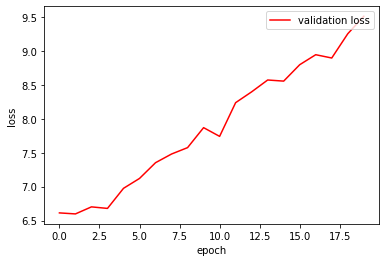

In [54]:
# training loss와 validation loss

fig, loss_ax = plt.subplots()
loss_ax.plot(history.history['val_loss'], 'r', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

## Top N 추천 성능 평가

In [55]:
# epoch = 2로 학습한 모델로 Top N 추천 성능을 평가해봅시다
# num_classes --> 전체 item 수
# negative sampling할 sample 수는 100개
neg_samples = 100
dnn_hidden_units = (64, 32)
model = CandidateGeneration(feature_columns, num_classes, neg_samples, dnn_hidden_units, dnn_activation='relu')
model.fit([train_X, train_y], batch_size=64, epochs=2, verbose=1, validation_data=([test_X, test_y]))

Epoch 1/2
430/430 [==============================] - 3s 4ms/step - loss: 3.6713 - val_loss: 6.6259
Epoch 2/2
430/430 [==============================] - 1s 3ms/step - loss: 2.3144 - val_loss: 6.6213


In [56]:
# test 데이터(X)로 예측을 수행합니다
# 여기서 test_y는 아무런 역할도 수행하지 않습니다

softmax = model.predict([test_X, test_y])
print(softmax.shape)
print(test_X)

(6543, 1934)
[array([0, 0, 0, ..., 0, 0, 0]), array([220, 217, 217, ..., 949, 546, 949]), array([1316, 1620, 1620, ..., 1316,  725, 1316]), array([5, 1, 1, ..., 5, 1, 5]), array([1648, 1648, 1648, ..., 1078, 1648, 1078]), array([43, 43, 43, ..., 13, 43, 13]), array([ 0,  0,  0, ..., 20,  0, 20]), array([ 808, 1141, 2974, ...,  451,  109,  641]), array([0, 1, 1, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 0, 0])]


In [60]:
# test_X의 개별 유저에 대해 1934개 item에 대한 확률값 획득
# top-10 아이템 추출
n=10
recomm = [list((-arr).argsort()[:n]) for arr in softmax]
recomm

[[26, 47, 235, 429, 799, 815, 421, 410, 548, 218],
 [199, 201, 462, 197, 204, 461, 200, 274, 195, 198],
 [199, 201, 462, 197, 204, 200, 461, 195, 274, 198],
 [26, 266, 264, 247, 272, 251, 281, 727, 429, 243],
 [799, 47, 802, 686, 235, 429, 548, 800, 719, 26],
 [26, 47, 235, 429, 799, 815, 421, 410, 548, 218],
 [199, 201, 462, 197, 204, 200, 461, 195, 274, 198],
 [199, 201, 462, 197, 204, 200, 461, 195, 274, 198],
 [199, 201, 462, 197, 204, 200, 195, 461, 274, 198],
 [26, 266, 264, 272, 247, 251, 727, 281, 429, 421],
 [26, 429, 421, 243, 218, 1277, 485, 1275, 235, 508],
 [799, 47, 26, 429, 235, 802, 548, 421, 686, 800],
 [26, 266, 264, 272, 247, 251, 281, 243, 429, 421],
 [26, 266, 264, 247, 272, 251, 281, 727, 429, 243],
 [26, 266, 264, 272, 247, 251, 727, 281, 429, 421],
 [26, 429, 47, 421, 235, 218, 799, 548, 243, 485],
 [199, 201, 462, 197, 204, 200, 195, 461, 274, 198],
 [199, 508, 201, 815, 410, 507, 461, 195, 203, 200],
 [26, 429, 421, 235, 218, 410, 47, 815, 243, 1277],
 [26, 42

In [62]:
test_y

array([[1662],
       [1272],
       [ 197],
       ...,
       [1566],
       [ 261],
       [1567]])

In [63]:
# hit_ratio 계산
hit = 0
for true_label, top_n in zip(test_y, recomm):
  if true_label[0] in top_n:
    hit += 1

print('hit_ratio : ', hit/len(test_y))

hit_ratio :  0.2537062509552193
